# Flight Delays EDA - Julia Notebook

This notebook is an interactive guide for exploring the flight delay dataset. We will walk through setting up the environment, loading the data, cleaning it, and creating visualizations to answer key questions about flight delays.

### 1. Setup Environment

First, we need to set up our Julia environment. The `Project.toml` file in the main project directory lists all the necessary packages. The following code cell will:
1. **Activate** the project environment.
2. **Add** packages for interactivity (`Interact` and `WebIO`).
3. **Instantiate** the environment, which downloads and installs all the required packages. You only need to run this cell once.

In [1]:
# Import the package manager
import Pkg

# Activate the project environment from the parent directory
Pkg.activate(joinpath(@__DIR__, ".."))

# Ensure interactive deps are available by default
Pkg.add(["Interact", "WebIO", "Widgets", "Blink"])
Pkg.instantiate()
try
    using WebIO
    WebIO.install_jupyter_nbextension()
catch e
    @warn "WebIO nbextension install skipped" exception=e
end


  Activating project at `C:\Users\chand\OneDrive\Desktop\tt\Flight_EDA_Analysis`
   Resolving package versions...
      Compat entries added for 
     Project No packages added to or removed from `C:\Users\chand\OneDrive\Desktop\tt\Flight_EDA_Analysis\Project.toml`
    Manifest No packages added to or removed from `C:\Users\chand\OneDrive\Desktop\tt\Flight_EDA_Analysis\Manifest.toml`


WebIO._IJuliaInit()

┌ Warning: WebIO nbextension install skipped
│   exception = The WebIO Jupyter extension must be installed using Python or Conda. See https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/ for more information.
└ @ Main In[1]:14


### 2. Load Project Code and Dependencies

Now we load the libraries we'll use for data manipulation and plotting, including our new interactivity packages. We also load our own `FlightEDA` module, which contains all the custom functions we've written for this project.

In [2]:
# Load standard libraries for data handling
using CSV, DataFrames, Statistics, Dates, Random

# Load the plotting library
using Plots

# Load libraries for interactive widgets
using Interact, WebIO

# Load our custom module from the 'src' directory
const SRC_DIR = abspath(joinpath(@__DIR__, "..", "src"))
include(joinpath(SRC_DIR, "FlightEDA.jl"))
using .FlightEDA

### 3. Load the Data

We are now ready to load the flight data. For quick analysis, we'll use a small sample file.

In [3]:
# Load the project configuration to get file paths
cfg = FlightEDA.load_config()

# Base directory for relative paths (works even if the notebook is run from notebooks/)
BASE_DIR = normpath(joinpath(@__DIR__, ".."))

# Set to `false` to load the full cleaned dataset instead of the sample
USE_SAMPLE = true

# Resolve the file path relative to the project root
file_to_load = joinpath(BASE_DIR, USE_SAMPLE ? cfg.data.sample_file : cfg.data.cleaned_file)

# Check if the file exists before trying to read it
if !isfile(file_to_load)
    error("Data file not found: $(file_to_load). You may need to run the cleaning script first or check your config.")
end

# Read the CSV file into a DataFrame and time the operation
println("Loading data from: $file_to_load")
@time df = CSV.read(file_to_load, DataFrame)

println("\nLoaded $(nrow(df)) rows and $(ncol(df)) columns.")
first(df, 5)

Loading data from: C:\Users\chand\OneDrive\Desktop\tt\Flight_EDA_Analysis\data/sample/flight_data_2024_sample.csv
 10.381922 seconds (25.34 M allocations: 1.216 GiB, 8.21% gc time, 168.70% compilation time: 54% of which was recompilation)

Loaded 10000 rows and 35 columns.


Row,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,dest,dest_city_name,dest_state_nm,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
,Int64,Int64,Int64,Int64,Date,String3,Float64,String3,String,String,String3,String,String,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,Float64?,Float64?,Int64,String1?,Int64,Float64,Float64?,Float64?,Float64,Int64,Int64,Int64,Int64,Int64
1,2024,4,18,4,2024-04-18,MQ,3535.0,DFW,"Dallas/Fort Worth, TX",Texas,RAP,"Rapid City, SD",South Dakota,1018,1015.0,-3.0,21.0,1036.0,1135.0,4.0,1149,1139.0,-10.0,0,missing,0,151.0,144.0,119.0,835.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,AA,148.0,CLT,"Charlotte, NC",North Carolina,PHX,"Phoenix, AZ",Arizona,1637,1633.0,-4.0,14.0,1647.0,1900.0,6.0,1923,1906.0,-17.0,0,missing,0,286.0,273.0,253.0,1773.0,0,0,0,0,0
3,2024,12,12,4,2024-12-12,9E,5440.0,CHA,"Chattanooga, TN",Tennessee,ATL,"Atlanta, GA",Georgia,1000,952.0,-8.0,13.0,1005.0,1034.0,8.0,1059,1042.0,-17.0,0,missing,0,59.0,50.0,29.0,106.0,0,0,0,0,0
4,2024,4,8,1,2024-04-08,WN,1971.0,OMA,"Omaha, NE",Nebraska,LAS,"Las Vegas, NV",Nevada,1330,1334.0,4.0,8.0,1342.0,1425.0,6.0,1430,1431.0,1.0,0,missing,0,180.0,177.0,163.0,1099.0,0,0,0,0,0
5,2024,2,16,5,2024-02-16,WN,862.0,BWI,"Baltimore, MD",Maryland,MYR,"Myrtle Beach, SC",South Carolina,1340,1333.0,-7.0,16.0,1349.0,1505.0,4.0,1510,1509.0,-1.0,0,missing,0,90.0,96.0,76.0,399.0,0,0,0,0,0


### 4. Clean Data and Engineer Features

The raw data needs some preparation before it's ready for analysis. We'll use the `enrich_features!` function from our `FlightEDA` module to add new columns.

In [4]:
# Use the function from our module to add new features to the DataFrame.
enrich_features!(df)

# Display the first few rows to see the new columns
println("DataFrame after adding features:")
first(df, 5)

DataFrame after adding features:


Row,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,dest,dest_city_name,dest_state_nm,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,hour_of_day,time_of_day,is_delayed,route
,Int64,Int64,Int64,Int64,Date,String3,Float64,String3,String,String,String3,String,String,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,Float64?,Float64?,Int64,String1?,Int64,Float64,Float64?,Float64?,Float64,Int64,Int64,Int64,Int64,Int64,Int64,String,Bool,String
1,2024,4,18,4,2024-04-18,MQ,3535.0,DFW,"Dallas/Fort Worth, TX",Texas,RAP,"Rapid City, SD",South Dakota,1018,1015.0,-3.0,21.0,1036.0,1135.0,4.0,1149,1139.0,-10.0,0,missing,0,151.0,144.0,119.0,835.0,0,0,0,0,0,10,Morning,false,DFW → RAP
2,2024,1,1,1,2024-01-01,AA,148.0,CLT,"Charlotte, NC",North Carolina,PHX,"Phoenix, AZ",Arizona,1637,1633.0,-4.0,14.0,1647.0,1900.0,6.0,1923,1906.0,-17.0,0,missing,0,286.0,273.0,253.0,1773.0,0,0,0,0,0,16,Evening,false,CLT → PHX
3,2024,12,12,4,2024-12-12,9E,5440.0,CHA,"Chattanooga, TN",Tennessee,ATL,"Atlanta, GA",Georgia,1000,952.0,-8.0,13.0,1005.0,1034.0,8.0,1059,1042.0,-17.0,0,missing,0,59.0,50.0,29.0,106.0,0,0,0,0,0,10,Morning,false,CHA → ATL
4,2024,4,8,1,2024-04-08,WN,1971.0,OMA,"Omaha, NE",Nebraska,LAS,"Las Vegas, NV",Nevada,1330,1334.0,4.0,8.0,1342.0,1425.0,6.0,1430,1431.0,1.0,0,missing,0,180.0,177.0,163.0,1099.0,0,0,0,0,0,13,Afternoon,false,OMA → LAS
5,2024,2,16,5,2024-02-16,WN,862.0,BWI,"Baltimore, MD",Maryland,MYR,"Myrtle Beach, SC",South Carolina,1340,1333.0,-7.0,16.0,1349.0,1505.0,4.0,1510,1509.0,-1.0,0,missing,0,90.0,96.0,76.0,399.0,0,0,0,0,0,13,Afternoon,false,BWI → MYR


### 5. Quick Data Quality Check

Let's perform a quick check on the data to see summary statistics and the number of missing values in each column.

In [5]:
# The describe function gives a statistical summary of the DataFrame
describe(df, :nmissing, :min, :median, :max, :mean)

Row,variable,nmissing,min,median,max,mean
,Symbol,Int64,Any,Any,Any,Union…
1,year,0,2024,2024.0,2024,2024.0
2,month,0,1,7.0,12,6.6132
3,day_of_month,0,1,16.0,31,15.843
4,day_of_week,0,1,4.0,7,3.9502
5,fl_date,0,2024-01-01,2024-07-06,2024-12-31,
6,op_unique_carrier,0,9E,,YX,
7,op_carrier_fl_num,0,1.0,2254.0,8771.0,2529.76
8,origin,0,ABE,,YUM,
9,origin_city_name,0,"Aberdeen, SD",,"Yuma, AZ",


### 6. Static Visualizations

First, we'll create some static plots to get a general overview of the data.

In [6]:
# Ensure the directory for saving plots exists
plot_dir = cfg.plots.dir
mkpath(plot_dir)

println("Plots will be saved to: $plot_dir")

Plots will be saved to: plots/2024


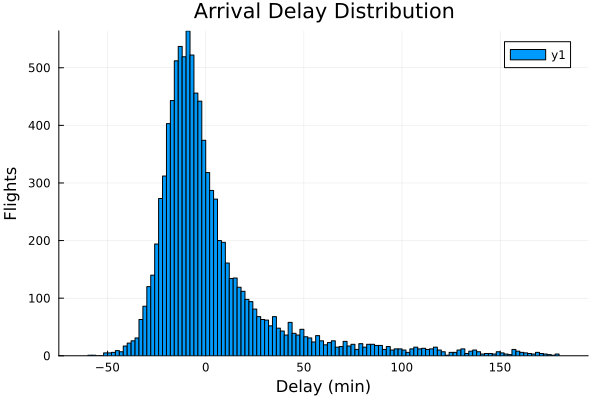

In [7]:
FlightEDA.plot_arrival_delay_histogram(df, cfg.plots.delay_lower, cfg.plots.delay_upper, plot_dir)
current()

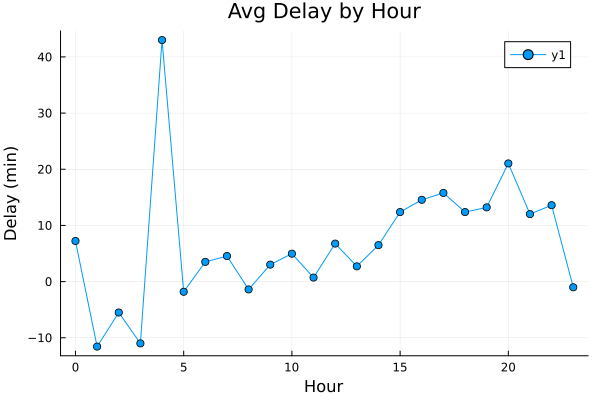

In [8]:
FlightEDA.plot_average_delay_by_hour(df, plot_dir)
current()

### 7. Interactive Analysis

Now let's add some interactivity. The widget below allows you to select a specific airline and see its average delay pattern by hour. This is much more powerful than a static plot, as it lets you compare airlines directly.

In [9]:
# Get a list of unique airline carriers to populate the dropdown
airlines = unique(skipmissing(df.op_unique_carrier))

# @manipulate creates an interactive widget.
# For each item in the `airline_picker` dropdown, it will re-run the code block.
@manipulate for airline_picker in dropdown(airlines)
    # Filter the DataFrame for the selected airline
    df_filtered = filter(:op_unique_carrier => ==(airline_picker), df)
    
    # Group by hour and calculate the mean arrival delay
    df_grouped = combine(groupby(df_filtered, :hour_of_day), :arr_delay => (mean ∘ skipmissing) => :mean_delay)
    sort!(df_grouped, :hour_of_day)
    
    # Create the plot
    plot(df_grouped.hour_of_day, df_grouped.mean_delay, 
        marker=:circle, 
        xlabel="Hour of Day", 
        ylabel="Average Delay (min)",
        title="Average Delay by Hour for $(airline_picker)",
        legend=false,
        grid=true
    )
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :select), Any[], Dict{Symbol, Any}(:attributes => Dict{Union{String, Symbol}, Any}(Symbol("data-bind") => "options : options_js, value : index, optionsText: 'key', optionsValue: 'val', valueAllowUnset: true, optionsAfterRender: disablePlaceholder")))], Dict{Symbol, Any}(:className => "select ")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("options_js" => (Observable(OrderedDict[OrderedDict{String, Any}("key" => String3("MQ"), "val" => 1, "id" => "idqE3su2lX"), OrderedDict{String, Any}("key" => String3("AA"), "val" => 2, "id" => "idglmAylv5"), OrderedDict{String, Any}("key" => String3("9E"), "val" => 3, "id" => "idNLuNB0pV"), OrderedDict{String, Any}("key" => String3("WN"), "val" => 4, "id" => "idve5coMoZ"), OrderedDict{String, Any}("key" => String3("G4"), "val" => 5, "id" => "idJWxivT6t"), OrderedDict{String, Any}("key" => String3("AS"), "val" => 6, "id" => "idf5aDwcAk"), OrderedDict{String, Any}("key" => String3("OO"), "val" => 7, "id" => "id8LwmvDt1"), OrderedDict{String, Any}("key" => String3("UA"), "val" => 8, "id" => "idJrynFOHj"), OrderedDict{String, Any}("key" => String3("DL"), "val" => 9, "id" => "idBAqLnila"), OrderedDict{String, Any}("key" => String3("F9"), "val" => 10, "id" => "idZX9Jaa90"), OrderedDict{String, Any}("key" => String3("B6"), "val" => 11, "id" => "idNenu0RoG"), OrderedDict{String, Any}("key" => String3("OH"), "val" => 12, "id" => "idpfxfnysL"), OrderedDict{String, Any}("key" => String3("NK"), "val" => 13, "id" => "id59AEBpuL"), OrderedDict{String, Any}("key" => String3("HA"), "val" => 14, "id" => "idiCTMfDE9"), OrderedDict{String, Any}("key" => String3("YX"), "val" => 15, "id" => "idKRRRdQ9O")]), nothing), "index" => (Observable{Any}(1), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\chand\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\chand\\.julia\\packages\\Knockout\\HReiN\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\chand\\.julia\\packages\\InteractBase\\8TTmI\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\chand\\.julia\\packages\\InteractBase\\8TTmI\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\chand\\.julia\\packages\\Interact\\PENUy\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Base.GenericCondition(ReentrantLock())), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n    

### 8. Summary & Next Steps

This notebook demonstrates a basic workflow for our flight delay analysis, including static and interactive plots. From here, you can:

- **Use the full dataset** by setting `USE_SAMPLE = false` for a more comprehensive analysis.
- **Generate all plots** by running `FlightEDA.generate_plots(cfg, df)`.
- **Add more interactive widgets** to explore other features like origin airport or day of the week.